In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Torch version: 2.6.0
CUDA available: True
GPU name: NVIDIA A10


10.81 M parameters
step 0: train loss 4.6544, val loss 4.6587
step 500: train loss 1.6522, val loss 1.6581
step 1000: train loss 1.2012, val loss 1.4122
step 1500: train loss 0.8386, val loss 1.4090
step 2000: train loss 0.4868, val loss 1.5877
step 2500: train loss 0.2506, val loss 1.8125
step 3000: train loss 0.1502, val loss 2.0381
step 3500: train loss 0.1139, val loss 2.2248
step 4000: train loss 0.0977, val loss 2.3499
step 4500: train loss 0.0889, val loss 2.4867
step 4999: train loss 0.0837, val loss 2.5751


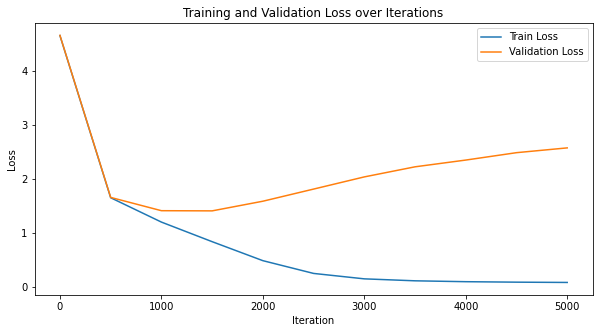

In [5]:
"""
I used the drake lyrics for this run. The reason we saw a discrepancy, more notably 
an eventual increase in validation loss is because the dataset is too small so the  
model started memorizing and overfitting.
"""

# hyperparameters
batch_size = 64       # how many independent sequences will we process in parallel?
block_size = 256      # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

# load the data
with open('drake-lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# create a list of unique characters and maps from characters to integers and vice versa
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading function
def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out


class Head(nn.Module):
    """One head of self-attention - processes one 'view' of the input"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        # Regularization: randomly zeros out some connections during training
        self.dropout = nn.Dropout(dropout)  

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Sequence length, Embedding dimension

        # Step 1: Create Q, K, V
        k = self.key(x)    # (B,T,head_size) "What do I know?"
        q = self.query(x)  # (B,T,head_size) "What am I looking for?"

        # Step 2: Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B,T,T)
        # Matrix multiply Q*K^T, scaled by sqrt(head_size)

        # Step 3: Apply mask (for decoder)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        # Makes future positions have -inf score

        # Step 4: Softmax to get probabilities (0-1)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)

        # Step 5: Dropout for regularization
        wei = self.dropout(wei)

        # Step 6: Weighted sum of values
        v = self.value(x)  # (B,T,head_size) "Actual content"
        out = wei @ v      # (B,T,head_size)
        
        return out
    
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)         # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,n_embd)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Instantiate and send model to device
model = GPTLanguageModel().to(device)
print(f"{sum(p.numel() for p in model.parameters())/1e6:.2f} M parameters")

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to record the losses and corresponding iteration steps
train_losses = []
val_losses = []
eval_steps = []

# Training loop
for iter in range(max_iters):
    # Evaluate loss on train and val sets at regular intervals
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")
        eval_steps.append(iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    # Get a batch of data
    xb, yb = get_batch('train')
    
    # Forward pass
    logits, loss = model(xb, yb)
    
    # Backward pass and optimizer step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Graph the loss curves after training
plt.figure(figsize=(10, 5))
plt.plot(eval_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()

In [8]:
df = pd.read_csv('spotify_millsongdata.csv')

In [9]:
print(df.columns)

Index(['artist', 'song', 'link', 'text'], dtype='object')


10.80 M parameters
step 0: train loss 4.3191, val loss 4.3198
step 500: train loss 1.6614, val loss 1.6567
step 1000: train loss 1.3508, val loss 1.3474
step 1500: train loss 1.2012, val loss 1.1964
step 2000: train loss 1.1296, val loss 1.1265
step 2500: train loss 1.0933, val loss 1.0971
step 3000: train loss 1.0771, val loss 1.0854
step 3500: train loss 1.0586, val loss 1.0599
step 4000: train loss 1.0384, val loss 1.0404
step 4500: train loss 1.0322, val loss 1.0345
step 5000: train loss 1.0256, val loss 1.0269
step 5500: train loss 1.0124, val loss 1.0169
step 5999: train loss 1.0001, val loss 1.0096


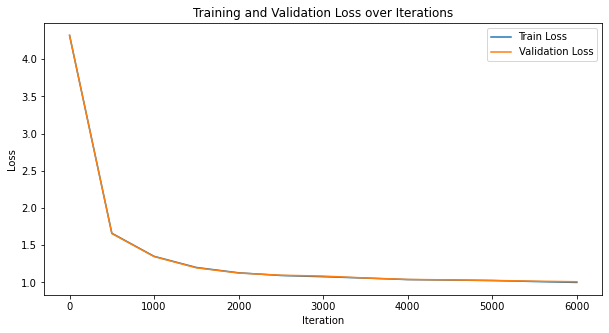

In [13]:
"""
Switched datasets here to spotify_millsongdata.csv a much larger dataset
"""

# hyperparameters
batch_size = 64       # how many independent sequences will we process in parallel?
block_size = 256      # what is the maximum context length for predictions?
max_iters = 6000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

# load the data
df = pd.read_csv('spotify_millsongdata.csv')
df = df.sample(frac=1, random_state=42)  # shuffling data to further help prevent overfitting
text = ' '.join(df['text'].dropna().astype(str).tolist())

# create a list of unique characters and maps from characters to integers and vice versa
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading function
def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)  # (B, T)
            correct = (preds == Y).float()
            accuracies[k] = correct.mean().item()
        
        out[split + '_loss'] = losses.mean().item()
        out[split + '_acc'] = accuracies.mean().item()
    model.train()
    return out


class Head(nn.Module):
    """One head of self-attention - processes one 'view' of the input"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        # Regularization: randomly zeros out some connections during training
        self.dropout = nn.Dropout(dropout)  

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Sequence length, Embedding dimension

        # Step 1: Create Q, K, V
        k = self.key(x)    # (B,T,head_size) "What do I know?"
        q = self.query(x)  # (B,T,head_size) "What am I looking for?"

        # Step 2: Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B,T,T)
        # Matrix multiply Q*K^T, scaled by sqrt(head_size)

        # Step 3: Apply mask (for decoder)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        # Makes future positions have -inf score

        # Step 4: Softmax to get probabilities (0-1)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)

        # Step 5: Dropout for regularization
        wei = self.dropout(wei)

        # Step 6: Weighted sum of values
        v = self.value(x)  # (B,T,head_size) "Actual content"
        out = wei @ v      # (B,T,head_size)
        
        return out
    
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)         # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,n_embd)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Instantiate and send model to device
model = GPTLanguageModel().to(device)
print(f"{sum(p.numel() for p in model.parameters())/1e6:.2f} M parameters")

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to record the losses and corresponding iteration steps
train_losses = []
val_losses = []
eval_steps = []

# Training loop
for iter in range(max_iters):
    # Evaluate loss on train and val sets at regular intervals
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['val']
        train_acc = losses['train_acc']
        val_acc = losses['val_acc']
        print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, train acc {train_acc:.4f}, val acc {val_acc:.4f}")
        eval_steps.append(iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    # Get a batch of data
    xb, yb = get_batch('train')
    
    # Forward pass
    logits, loss = model(xb, yb)
    
    # Backward pass and optimizer step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Graph the loss curves after training
plt.figure(figsize=(10, 5))
plt.plot(eval_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()

10.80 M parameters
step 0: train loss 4.4181, val loss 4.4173, train acc 0.0037, val acc 0.0037
step 500: train loss 1.6549, val loss 1.6485, train acc 0.5092, val acc 0.5107
step 1000: train loss 1.3376, val loss 1.3351, train acc 0.5979, val acc 0.5987
step 1500: train loss 1.1976, val loss 1.1989, train acc 0.6420, val acc 0.6416
step 2000: train loss 1.1290, val loss 1.1294, train acc 0.6615, val acc 0.6616
step 2500: train loss 1.0977, val loss 1.1013, train acc 0.6705, val acc 0.6699
step 3000: train loss 1.0751, val loss 1.0781, train acc 0.6773, val acc 0.6769
step 3500: train loss 1.0545, val loss 1.0552, train acc 0.6819, val acc 0.6817
step 4000: train loss 1.0421, val loss 1.0439, train acc 0.6866, val acc 0.6858
step 4500: train loss 1.0252, val loss 1.0339, train acc 0.6903, val acc 0.6879
step 5000: train loss 1.0221, val loss 1.0240, train acc 0.6917, val acc 0.6914
step 5500: train loss 1.0072, val loss 1.0151, train acc 0.6950, val acc 0.6933
step 5999: train loss 1.0

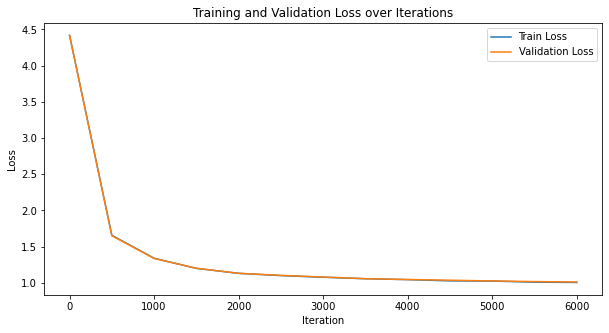

In [18]:
# hyperparameters
batch_size = 64       # how many independent sequences will we process in parallel?
block_size = 256      # what is the maximum context length for predictions?
max_iters = 6000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

# load the data
df = pd.read_csv('spotify_millsongdata.csv')
df = df.sample(frac=1, random_state=42)  # shuffling data to further help prevent overfitting
text = ' '.join(df['text'].dropna().astype(str).tolist())

# create a list of unique characters and maps from characters to integers and vice versa
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading function
def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)
    
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            
            preds = torch.argmax(logits, dim=-1)  # (B * T,)
            Y_reshaped = Y.view_as(preds)         # reshape target to (B, T)
            correct = (preds == Y_reshaped).float()
            accuracies[k] = correct.mean().item()
        
        out[split + '_loss'] = losses.mean().item()
        out[split + '_acc'] = accuracies.mean().item()
    model.train()
    return out


class Head(nn.Module):
    """One head of self-attention - processes one 'view' of the input"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        # Regularization: randomly zeros out some connections during training
        self.dropout = nn.Dropout(dropout)  

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Sequence length, Embedding dimension

        # Step 1: Create Q, K, V
        k = self.key(x)    # (B,T,head_size) "What do I know?"
        q = self.query(x)  # (B,T,head_size) "What am I looking for?"

        # Step 2: Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B,T,T)
        # Matrix multiply Q*K^T, scaled by sqrt(head_size)

        # Step 3: Apply mask (for decoder)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        # Makes future positions have -inf score

        # Step 4: Softmax to get probabilities (0-1)
        wei = F.softmax(wei, dim=-1)  # (B,T,T)

        # Step 5: Dropout for regularization
        wei = self.dropout(wei)

        # Step 6: Weighted sum of values
        v = self.value(x)  # (B,T,head_size) "Actual content"
        out = wei @ v      # (B,T,head_size)
        
        return out
    
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)         # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,n_embd)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]  # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Instantiate and send model to device
model = GPTLanguageModel().to(device)
print(f"{sum(p.numel() for p in model.parameters())/1e6:.2f} M parameters")

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to record the losses and corresponding iteration steps
train_losses = []
val_losses = []
eval_steps = []

# Training loop
for iter in range(max_iters):
    # Evaluate loss on train and val sets at regular intervals
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train_loss']
        val_loss = losses['val_loss']
        train_acc = losses['train_acc']
        val_acc = losses['val_acc']
        print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, train acc {train_acc:.4f}, val acc {val_acc:.4f}")
        eval_steps.append(iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    # Get a batch of data
    xb, yb = get_batch('train')
    
    # Forward pass
    logits, loss = model(xb, yb)
    
    # Backward pass and optimizer step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
# Graph the loss curves after training
plt.figure(figsize=(10, 5))
plt.plot(eval_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()